# Temporal Split
To split users based on the different timestamp

In [1]:
import pandas as pd
from collections import defaultdict
from datetime import datetime
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
ds_name = "Yelp"

Using the train dataset we generate some dictionary to have user and item profile based on the frequency of visit.

In [3]:
# read check-in frequency from train data
train_data = open(f"datasets/{ds_name}/{ds_name}_train.txt", 'r').readlines()
# uid_to_lid: shows the visited locations by a user (it is based on train set so there is no repeated lid; thus we use a set to show them)
# uid -> set({lids})
uid_to_lid = defaultdict(set)
# uid_to_freq: to show the numebr of checkins frequency per user
# uid -> check-in freq
uid_to_freq = dict()
# lid_to_freq: to show the number of time a location has been visted by users
# lid -> check-in freq
lid_to_freq = dict()

for eachline in tqdm(train_data):
    uid, lid, freq = eachline.strip().split()
    uid, lid, freq = int(uid), int(lid), int(freq)
    if uid in uid_to_lid.keys():
        uid_to_lid[uid].add(lid)
        uid_to_freq[uid] += freq
    else:
        uid_to_lid[uid] = {lid}
        uid_to_freq[uid] = freq

    if lid in lid_to_freq.keys():
        lid_to_freq[lid] += freq
    else:
        lid_to_freq[lid] = freq

100%|██████████| 196866/196866 [00:00<00:00, 295044.88it/s]


In [4]:
# read checkins data
checkins_data = pd.read_csv(f"datasets/{ds_name}/{ds_name}_checkins.txt", sep='\t', names=['uid', 'lid', 'ctime'])

In [5]:
# number of checkins in train data
sum(uid_to_freq.values())

774320

In [6]:
# time (hour) -> no. of check-ins
# to generate the plot
time_to_checkins = dict()

for eachline in tqdm(checkins_data.itertuples(index=True)):
    # Check if record exsists in train data (based on lid/location)
    # We have 70% of check-ins data in the train set and if a user's checkins on a specific location with its frequency happns in train,
    # it only happens in train set not test/dev sets.
    if eachline.lid in uid_to_lid[eachline.uid]:
        ctime = datetime.fromtimestamp(eachline.ctime).strftime('%Y-%m-%dT%H:%M:%S')
        ctime_datetime_obj = datetime.strptime(ctime, '%Y-%m-%dT%H:%M:%S')
        # checking the hour
        hour = ctime_datetime_obj.hour
        if hour in time_to_checkins.keys():
            time_to_checkins[hour] += 1
        else:
            time_to_checkins[hour] = 1

301753it [00:05, 58917.77it/s]


IndexError: tuple index out of range

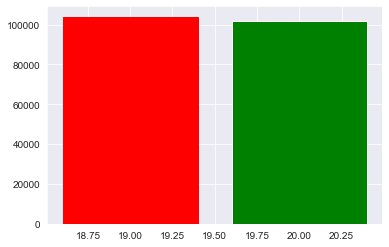

In [7]:
# time check-ins plot
barlist = plt.bar(list(time_to_checkins.keys()), time_to_checkins.values(), color='g')
barlist[0].set_color('r')
barlist[2].set_color('r')
barlist[3].set_color('r')
barlist[4].set_color('r')
barlist[5].set_color('r')
barlist[7].set_color('r')
barlist[9].set_color('r')
barlist[10].set_color('r')
barlist[11].set_color('r')
barlist[16].set_color('r')
barlist[22].set_color('r')
plt.xticks(np.arange(len(list(time_to_checkins.keys()))))
plt.xlabel("Time (Hour)", fontsize=15)
plt.ylabel("Number of check-ins", fontsize=15)
plt.margins(0)
plt.savefig(f"plots/{ds_name}/checkins_time_hist.pdf", bbox_inches="tight")

Here we split the check-in from the train data based on leisure and working timestamp.

In [5]:
# uid/lid -> no. of working check-ins
user_working_checkins = dict()
item_working_checkins = dict()
# uid/lid -> no. of leisure check-ins
user_leisure_checkins = dict()
item_leisure_checkins = dict()

for eachline in tqdm(checkins_data.itertuples(index=True)):
    # check if record exsists in train data (based on lid/location)
    if eachline.lid in uid_to_lid[eachline.uid]:
        is_working = 0
        is_leisure = 0
        ctime = datetime.fromtimestamp(eachline.ctime).strftime('%Y-%m-%dT%H:%M:%S')
        ctime_datetime_obj = datetime.strptime(ctime, '%Y-%m-%dT%H:%M:%S')
        # checking the weekday or weekend
        if ctime_datetime_obj.weekday() < 5:
            # 0 to 4 weekdays
            if ctime.split('T')[1] >= '08:00:00' and ctime.split('T')[1] <= '18:00:00':
                is_working = 1
            else:
                is_leisure = 1
        else:
            # 5 or 6 weekends
            # sun and sat
            is_leisure = 1
            
        # user
        if eachline.uid in user_working_checkins.keys():
            user_working_checkins[eachline.uid] += is_working
            user_leisure_checkins[eachline.uid] += is_leisure
        else:
            user_working_checkins[eachline.uid] = is_working
            user_leisure_checkins[eachline.uid] = is_leisure
        # item
        if eachline.lid in item_working_checkins.keys():
            item_working_checkins[eachline.lid] += is_working
            item_leisure_checkins[eachline.lid] += is_leisure
        else:
            item_working_checkins[eachline.lid] = is_working
            item_leisure_checkins[eachline.lid] = is_leisure

301753it [00:05, 55287.85it/s]


In [9]:
# check
sample_user = 3
uid_to_freq[sample_user] == user_working_checkins[sample_user] + user_leisure_checkins[sample_user]

False

In [10]:
# check
sample_item = 3
lid_to_freq[sample_item] == item_working_checkins[sample_item] + item_leisure_checkins[sample_item]

False

In [11]:
users_checkins = pd.DataFrame(columns=['uid', 'profile_size', 'leisure_size', 'working_size', 'leisure_precentage', 'working_precentage'])

In [12]:
users_checkins.head()

,uid,profile_size,leisure_size,working_size,leisure_precentage,working_precentage


In [13]:
for eachuid in tqdm(uid_to_lid.keys()):
    users_checkins = users_checkins.append({'uid': float(eachuid), 'profile_size': float(uid_to_freq[eachuid]),
    'leisure_size': float(user_leisure_checkins[eachuid]), 'working_size': float(user_working_checkins[eachuid]),
    'leisure_precentage': float(user_leisure_checkins[eachuid]) / float(uid_to_freq[eachuid]),
    'working_precentage': float(user_working_checkins[eachuid]) / float(uid_to_freq[eachuid])}, ignore_index=True)

100%|██████████| 7135/7135 [00:12<00:00, 589.98it/s]


In [14]:
users_checkins.head()

,uid,profile_size,leisure_size,working_size,leisure_precentage,working_precentage
0,0.0,113.0,27.0,0.0,0.238938,0.0
1,1.0,31.0,8.0,0.0,0.258065,0.0
2,2.0,451.0,120.0,0.0,0.266075,0.0
3,3.0,44.0,11.0,0.0,0.250000,0.0
4,4.0,440.0,108.0,0.0,0.245455,0.0


In [ ]:
# 1: no. of working time vs no. of leisure time
# plot on working and leisure checkin size (number of working time vs number of leisure time - with x=y line)
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.regplot(data=users_checkins, x="working_size", y="leisure_size", ax=ax)
p2 = sns.lineplot(data=users_checkins, x='working_size', y='working_size', color='orange', ax=ax)
p1.set_xlabel("No. of Check-ins in Working Time", size=13)
p1.set_ylabel("No. of Check-ins in Leisure Time", size=13)
plt.savefig(f"plots/{ds_name}/working_leisure_count.pdf", bbox_inches="tight")

In [ ]:
# 2: Percentage of working time vs user profile
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.regplot(data=users_checkins, x='profile_size', y='working_precentage', ax=ax)
p1.set_xlabel("Users Profile Size", size=13)
p1.set_ylabel("Precentage of Check-ins in Working Time", size=13)
plt.savefig(f"plots/{ds_name}/working_pre_profile_size.pdf", bbox_inches="tight")

In [ ]:
# 3: Percentage of leisure time vs user profile
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.regplot(data=users_checkins, x='profile_size', y='leisure_precentage', ax=ax)
p1.set_xlabel("Users Profile Size", size=13)
p1.set_ylabel("Precentage of Check-ins in Leisure Time", size=13)
plt.savefig(f"plots/{ds_name}/leisure_pre_profile_size.pdf", bbox_inches="tight")

In [ ]:
# 4: No. of working time vs. Profile size
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.regplot(data=users_checkins, x='working_size', y='profile_size', ax=ax)
p2 = sns.lineplot(data=users_checkins, x='working_size', y='working_size', color='orange', ax=ax)
p1.set_xlabel("No. of Check-ins in Working Time", size=13)
p1.set_ylabel("Users Profile Size", size=13)
plt.savefig(f"plots/{ds_name}/working_count_profile_size.pdf", bbox_inches="tight")

In [ ]:
# 5: No. of leisure time vs. Profile size
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.regplot(data=users_checkins, x='leisure_size', y='profile_size', ax=ax)
p2 = sns.lineplot(data=users_checkins, x='leisure_size', y='leisure_size', color='orange', ax=ax)
p1.set_xlabel("No. of Check-ins in Leisure Time", size=13)
p1.set_ylabel("Users Profile Size", size=13)
plt.savefig(f"plots/{ds_name}/leisure_count_profile_size.pdf", bbox_inches="tight")

In [ ]:
# 6: No. of leisure time vs No. of working time
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.regplot(data=users_checkins, x='leisure_size', y='working_size', ax=ax)
p2 = sns.lineplot(data=users_checkins, x='leisure_size', y='leisure_size', color='orange', ax=ax)
p1.set_xlabel("No. of Check-ins in Leisure Time", size=13)
p1.set_ylabel("No. of Check-ins in Working Time", size=13)
plt.savefig(f"plots/{ds_name}/leisure_working_count.pdf", bbox_inches="tight")

### User leisure and working groups

In [15]:
# compute user leisure precentage
user_leisure_precentage = dict()
for uid in uid_to_freq.keys():
    user_leisure_precentage[uid] = user_leisure_checkins[uid] * (user_leisure_checkins[uid] / uid_to_freq[uid])

# sort based on leisure precentage
sorted_user_leisure_precentage = {k: v for k, v in sorted(user_leisure_precentage.items(), key=lambda item: item[1], reverse=True)}

In [16]:
# compute user leisure precentage
user_working_precentage = dict()
for uid in uid_to_freq.keys():
    user_working_precentage[uid] = user_working_checkins[uid] * (user_working_checkins[uid] / uid_to_freq[uid])

# sort based on leisure precentage
sorted_user_working_precentage = {k: v for k, v in sorted(user_working_precentage.items(), key=lambda item: item[1], reverse=True)}

In [18]:
# top no. of users based on precentage and fraction
top_fraction = 0.2
top_num = round(0.2 * len(uid_to_freq.keys()))

In [ ]:
# leisure-focused users
leisure_focused_users = list(sorted_user_leisure_precentage.keys())[:top_num]
# working-focused users
working_focused_users = list(sorted_user_leisure_precentage.keys())[-top_num:]

In [ ]:
working_ids = open(f"groups/user_groups/{ds_name}/working.txt", 'w')
leisure_ids = open(f"groups/user_groups/{ds_name}/leisure.txt", 'w')

for uid in working_focused_users:
        working_ids.write(str(uid) + '\n')

for uid in leisure_focused_users:
        leisure_ids.write(str(uid) + '\n')
        
working_ids.close()
leisure_ids.close()

### Item groups

In [ ]:
# compute item leisure precentage
item_leisure_precentage = dict()
for lid in lid_to_freq.keys():
    item_leisure_precentage[lid] = item_leisure_checkins[lid] * (item_leisure_checkins[lid] / lid_to_freq[lid])

# sort based on leisure precentage
sorted_item_leisure_precentage = {k: v for k, v in sorted(item_leisure_precentage.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
# top no. of users based on precentage and fraction
top_fraction = 0.2
top_num = round(0.2 * len(lid_to_freq.keys()))

In [ ]:
# leisure-focused items
leisure_focused_items = list(sorted_item_leisure_precentage.keys())[:top_num]
# working-focused items
working_focused_items = list(sorted_item_leisure_precentage.keys())[-top_num:]

In [ ]:
working_items = open(f"groups/item_groups/{ds_name}/working.txt", 'w')
leisure_items = open(f"groups/item_groups/{ds_name}/leisure.txt", 'w')

for lid in working_focused_items:
        working_items.write(str(lid) + '\n')

for lid in leisure_focused_items:
        leisure_items.write(str(lid) + '\n')
        
working_items.close()
leisure_items.close()